In [122]:
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import numpy as np
import tqdm

In [2]:
tt = SMTT("torch")

In [3]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [4]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_15197/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


- Sort games by game length [X]
- batch inference for games of length [X]
- extract activations with hooks [X]
- train autoencoder on data reconstruction (anthropic has tips here) [X]
- find good metrics + start looking at data (anthropic has tips here)

In [5]:
all_games = game.generate_all_games([game.Board()])

In [6]:
len(all_games)

255168

In [7]:
games_len_dict = {5: [], 6: [], 7: [], 8: [], 9: []}
for game in all_games:
    games_len_dict[len(game.moves_played)].append(game.moves_played)

In [8]:
s = 0
for key in games_len_dict.keys():
    s += len(games_len_dict[key])
print(s)

255168


In [9]:
games_len_tensors = {}
for key in games_len_dict.keys():
    games_len_tensors[key] = torch.stack(
        [torch.tensor([10] + game) for game in games_len_dict[key]]
    )

In [10]:
games_len_tensors.keys()

dict_keys([5, 6, 7, 8, 9])

In [11]:
games_len_tensors[9].device

device(type='cpu')

In [12]:
# Activation hook
def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        with torch.inference_mode():
            handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
            _ = model(seq)
            activations = model.blocks[0].mlp.hook_post.captured_activations
            handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [13]:
# a = neuron_activations(games_len_tensors[5])[:, -1]

In [14]:
# a.numel() * a.element_size()

In [15]:
# b = neuron_activations(games_len_tensors[9])
# reporter = MemReporter()
# reporter.report()

In [16]:
torch.cuda.empty_cache()

In [17]:
length = games_len_tensors[9].shape[0]
batchy_size = length // 4

In [18]:
# Inference loop
# will there be a difference across game lengths?
# Doesn't fit in memory?
# 512 neurons * 255168 games * 32 bit floats * 10 seq len = 5.22 gigabytes???

all_acts = []
for i, key in enumerate(games_len_tensors.keys()):
    print(i)
    if games_len_tensors[key].shape[0] < batchy_size:
        acts = neuron_activations(games_len_tensors[key])
        all_acts.append(acts.to("cpu"))
    else:
        for j in tqdm.trange(
            0, games_len_tensors[key].shape[0], batchy_size, desc=f"Batch {i}"
        ):
            acts = neuron_activations(games_len_tensors[key][j : j + batchy_size])
            all_acts.append(acts.to("cpu"))
    print(acts.device)
    torch.cuda.empty_cache()

0
cuda:0
1
cuda:0
2


Batch 2: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


cuda:0
3


Batch 3: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


cuda:0
4


Batch 4: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

cuda:0


In [19]:
reporter = MemReporter()
reporter.report()

/home/obayyub/.local/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cpu
Tensor0                                      (31968, 8, 512)   499.50M
Tensor1                                      (15984, 8, 512)   249.75M
Tensor2                                      (31968, 9, 512)   561.94M
Tensor3                                      (31968, 9, 512)   561.94M
Tensor4                                       (8640, 9, 512)   151.88M
Tensor5                                     (31968, 10, 512)   624.38M
Tensor6                                     (31968, 10, 512)   624.38M
Tensor7                                     (31968, 10, 512)   624.38M
Tensor8                                     (31968, 10, 512)   624.38M
Tensor9                                         (127872, 10)     9.76M
Tensor10                                      (1440, 6, 512)    16.88M
Tensor11                                      (5328, 

In [20]:
games_len_tensors[9].device

device(type='cpu')

In [33]:
for act in all_acts:
    tt(act)

Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (1440)
    |__dim_1 (6)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (5328)
    |__dim_1 (7)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (31968)
    |__dim_1 (8)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (15984)
    |__dim_1 (8)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (31968)
    |__dim_1 (9)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (31968)
    |__dim_1 (9)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (8640)
    |__dim_1 (9)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (31968)
    |__dim_1 (10)
    |__dim_2 (512)
Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (31968)
    |__dim_1 (10)
    |__dim_2 (512)
Tensor (dtype: torch.float32)

In [34]:
out = 0
for act in all_acts:
    out += act.shape[0] * act.shape[1]
print(out)


2361456


In [29]:
act_data = torch.cat(
    [einops.rearrange(acts, "batch seq dim -> (batch seq) dim") for acts in all_acts],
    dim=0,
)

In [23]:
torch.save(act_data, "all_games_act_data.pt")

Note that since there's a lot of repeated phrases in the input, we'll have lots of identical activations. Not sure how that'll change things yet though..

In [30]:
tt(act_data)

Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (2361456)
    |__dim_1 (512)


In [123]:
autoenc = models.SparseAutoEncoder(512, 1024).to("cuda")

loss_fn = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(autoenc.parameters(), lr=1e-4, weight_decay=1e-3)

In [124]:
act_data = torch.load("all_games_act_data.pt")

In [125]:
tt(act_data)

Tensor (dtype: torch.float32)
    |  (device: cpu)
    |__dim_0 (2361456)
    |__dim_1 (512)


In [126]:
act_data[0].mean()

tensor(0.6646)

In [127]:
test = loss_fn(torch.zeros(2,2), torch.ones(2,2), reduction="none")
test

tensor([[1., 1.],
        [1., 1.]])

In [128]:
epochs = 10
batch_size = 2**15
lam = 1e-7
losses = []
for epoch in range(epochs):
    for batch in range(0, act_data.shape[0], batch_size):
        dat = act_data[batch : batch + batch_size].to("cuda")
        
        reg, guess = autoenc(dat)
        mse_loss = loss_fn(guess, dat)
        
        sparse_loss = lam * reg
        #sparse_loss = 0
        loss = mse_loss + sparse_loss
        #losses.append(interpretability.numpy(loss))
        losses.append([interpretability.numpy(mse_loss), sparse_loss])
        optimizer.zero_grad()
        loss.backward()
        print(losses[-1])
        optimizer.step()

        with torch.no_grad():
            last_loss = loss_fn(guess, dat, reduction='none')

[array(3.5028396, dtype=float32), tensor(1.4583, device='cuda:0', grad_fn=<MulBackward0>)]
[array(3.1063895, dtype=float32), tensor(1.3853, device='cuda:0', grad_fn=<MulBackward0>)]
[array(2.8665009, dtype=float32), tensor(1.3391, device='cuda:0', grad_fn=<MulBackward0>)]
[array(2.6947346, dtype=float32), tensor(1.3192, device='cuda:0', grad_fn=<MulBackward0>)]
[array(2.4454494, dtype=float32), tensor(1.2715, device='cuda:0', grad_fn=<MulBackward0>)]
[array(2.1855767, dtype=float32), tensor(1.2156, device='cuda:0', grad_fn=<MulBackward0>)]
[array(2.0985541, dtype=float32), tensor(1.1785, device='cuda:0', grad_fn=<MulBackward0>)]
[array(2.0177398, dtype=float32), tensor(1.1414, device='cuda:0', grad_fn=<MulBackward0>)]
[array(1.7901512, dtype=float32), tensor(1.0953, device='cuda:0', grad_fn=<MulBackward0>)]
[array(1.5927267, dtype=float32), tensor(1.0399, device='cuda:0', grad_fn=<MulBackward0>)]
[array(1.5390517, dtype=float32), tensor(1.0239, device='cuda:0', grad_fn=<MulBackward0>)]

In [129]:
last_loss.sort()

torch.return_types.sort(
values=tensor([[5.3487e-09, 7.1918e-09, 3.5960e-08,  ..., 2.6246e-01, 2.6246e-01,
         2.8048e-01],
        [4.6919e-07, 6.7657e-07, 1.9079e-06,  ..., 1.0078e+00, 1.0573e+00,
         1.2321e+00],
        [8.9489e-07, 3.3453e-06, 1.2714e-05,  ..., 6.7506e-01, 7.4010e-01,
         1.2074e+00],
        ...,
        [2.1759e-07, 4.2643e-07, 5.7342e-06,  ..., 4.2370e-01, 4.3755e-01,
         6.2129e-01],
        [1.9072e-06, 2.4738e-06, 3.0429e-06,  ..., 5.2393e-01, 5.3203e-01,
         5.3374e-01],
        [1.9040e-10, 1.1574e-06, 1.2861e-06,  ..., 2.5548e-01, 2.7523e-01,
         3.1692e-01]], device='cuda:0'),
indices=tensor([[508, 314, 184,  ..., 393,   7, 168],
        [410, 507, 110,  ..., 285, 461, 308],
        [213, 335, 320,  ..., 135, 209, 368],
        ...,
        [191, 443, 265,  ..., 348, 406, 243],
        [265, 289, 176,  ...,  97, 158, 252],
        [ 40, 483, 242,  ..., 209, 153, 237]], device='cuda:0'))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

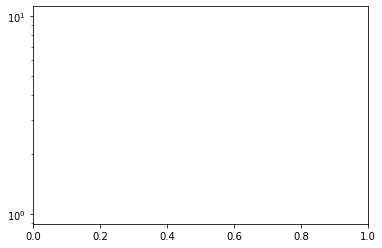

In [130]:
plt.yscale("log")
plt.plot(range(len(losses)), losses)

Great. Now we've got an autoencoder, what do we do with it?

In [131]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(
        local_encoder.W_in.shape[1], dtype=torch.float32
    ).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = act_data[torch.randperm(len(act_data))][: 2**14].to("cuda")

        hidden = local_encoder.get_act_density(tokens)

        act_freq_scores += hidden
        total += tokens.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

In [132]:
freqs = get_freqs(local_encoder=autoenc)

100%|██████████| 25/25 [00:23<00:00,  1.07it/s]

Num dead tensor(0.1621, device='cuda:0')


In [52]:
tt(freqs)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (1024)


In [133]:
print(freqs[112]*act_data.shape[0])

tensor(2202.3345, device='cuda:0')


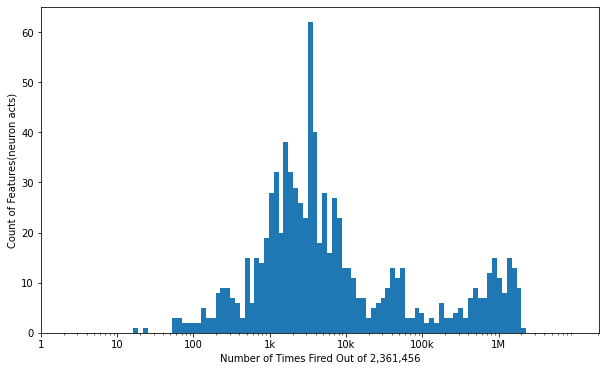

In [134]:
x = interpretability.numpy(freqs)*act_data.shape[0];
# x = interpretability.numpy(freqs)
x = x[np.isfinite(x)];
fig, ax = plt.subplots();
#set figure size
fig.set_size_inches(10, 6);
ax.hist(x, bins=np.logspace(np.log10(5), np.log10(10000000), 100));
ax.set_xscale("log");
#x label
#ax.xlabel("Number of Moves (log 10 scale)");
#y label
#ax.ylabel("Count of Features(neuron acts)");
#set xtick and labels of ticks
tick_positions = [1, 10, 100, 1000, 10000, 100000, 1000000]
tick_labels = ['1', '10', '100', '1k', '10k', '100k', '1M']
ax.set_xticks(tick_positions);
ax.set_xticklabels(tick_labels);
#ax.get_xaxis().set_major_formatter(plt.ScalarFormatter());
ax.set_xlabel("Number of Times Fired Out of 2,361,456");
ax.set_ylabel("Count of Features(neuron acts)");

In [136]:
torch.save(autoenc, "sparse_autoencoder_on_activations_02NOV2023.pt")